In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Dataset imported

# Dataset
df = pd.read_csv("final_dataset.csv")

# Shape and structure
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
df.head()

In [ ]:
# Droping unnecessary and repetitive columns to enhance the model evaluaiton and 
# reduce the size of the overall data

drop_cols = ["system:index", "ndvi", "ndvi_missing_flag","urban_flag","fire_modis"]  
df = df.drop(columns=drop_cols, errors="ignore")

In [ ]:
# To showcase the final rows and columns

df.shape

In [ ]:
# To view the first five columns

df.head()

In [ ]:
# Converting date to datetime datatype 

df['date'] = pd.to_datetime(df['date'])

### In the below code I have removed the data which extent my study area for better performance in the model. I have removed by finding out the id numbers in my finshet{ArcGIS}. Now the dataset was actually reduce a lot in terms of space which is cruital in machine learning


In [ ]:
# make sure id is integer
df['id'] = pd.to_numeric(df['id'], errors='coerce').astype('Int64')

# drop ids 1–225 and 1216–1575 (inclusive), for all dates
mask_to_drop = df['id'].between(0, 225) | df['id'].between(1216, 1575)
df_kept = df[~mask_to_drop].copy()

# optional sanity checks
# Expect 990 points/day remaining if you originally had 1575/day
per_day_counts_before = df.groupby('date')['id'].size().head()        # peek
per_day_counts_after  = df_kept.groupby('date')['id'].size().head()   # peek
print("Rows before:", len(df), " | after:", len(df_kept))

# save
df_kept.to_csv("wildfire_data_filtered_1.csv", index=False)

In [ ]:
df_1=pd.read_csv("wildfire_data_filtered_1.csv")
df_1.shape

In [ ]:
# Always remeber to drop the ids

drop_cols = ["id"]  # replace with your actual column names
df_1= df_1.drop(columns=drop_cols, errors="ignore")

In [ ]:
# To check the datatypes of every predictors(columns)

df_1.dtypes

### Important : In the above code, slope_cat(slope category) was actually an object we it has alphabets. In ML, most of the model will take lot of time if it has alphabets as predictors, converting into alphanumeric or numeric(best) would be better for the model to learn the instances.

##### In my case, slope category has data like, steep, moderate, too steep, gentle. I converted them into numerics like 1,2,3,4. In here, I am making a easy route to my model to learn. 

df_1['slope_cat'].value_counts()

In [ ]:
slope_map = {
    "flat_gentle": 0,
    "moderate": 1,
    "steep": 2,
    "very_steep": 3
}

# Apply mapping
df_1["slope_cat"] = df_1["slope_cat"].map(slope_map)


##### To check the Zero percents in every columns. In ML, modern models can learn zeros and train regarding that where statiscal model will struggle and show big variation in the test set. Always check the Zeros if possible and convert or interpolate as a meaningful data rather than a NAN.

##### In terms of geography, many locations has actually a meaning(represents something) for Zero. Careful, or the result may be sparse.

In [ ]:
zero_counts = (df_1 == 0).sum()
print(zero_counts)

## Raw datasets are not included due to size, licensing, and ongoing publication considerations. If any colleague wants it can provide under the lincense considerations.

##### converting temperature from K to C˚. Multilpying vapour pressure density into 1000 to find the least number(float) as a value.

In [ ]:
# Convert temperatures into real time values to save the size of the dataset. Eventhough it not gonna play a huge role.

for col in ['tmax_c','tmin_c','tmean_c']:
    df_1[col] = (df_1[col] + 273.15) * 10 - 273.15
df_1

In [ ]:
df_1['vpd_kpa'] = df_1['vpd_kpa'] * 1000

##### Just make sure of check any anamolies in key predictors like temperature, wind etc...,

In [ ]:
# Just to make sure there is no anamolies(like NANs and missing values or negative values)


threshold_high = 1e3   # adjust
threshold_low  = 1e-8

plt.figure(figsize=(12,5))
plt.plot(df_1[col].values, label="values", linewidth=0.5)

# highlight anomalies
outliers = df_1[(np.abs(df_1[col]) > threshold_high) | ((np.abs(df_1[col]) < threshold_low) & (df_1[col] != 0))]
plt.scatter(outliers.index, outliers[col], color="red", label="outliers")

plt.title(f"Line graph with anomalies in {col}")
plt.xlabel("Row index")
plt.ylabel(col)
plt.legend()
plt.show()

In [ ]:
# By taking average, the wind speed in mid of the year is actually fluctuating and gradually decreasing at the end of the year. Typically connects Santa Ana Winds as we discussed in introdution

df_1.groupby(df_1['date'].dt.month)['wind_ms'].mean().plot(kind='line', marker='o')
plt.title("Monthly Average Wind Speed")
plt.xlabel("Month")
plt.ylabel("Wind Speed (m/s)")
plt.show()

##### Make sure to research some articles regarding your study area and aligns with our data to show your data really has a value. In this below image the average speed of wind in every month of 2024 as shown in pacific palisades, California

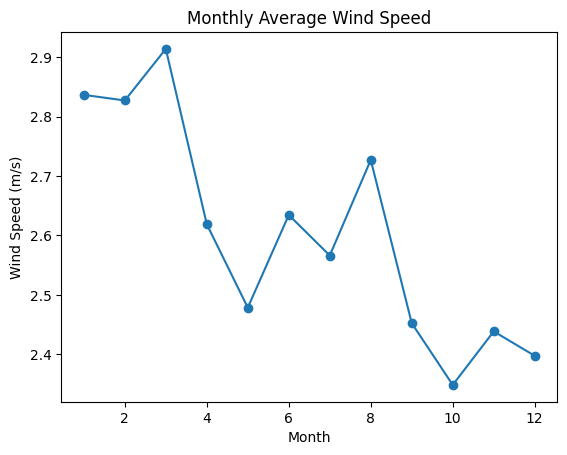

        --------------------------------------

##### This below one is about ndvi of pacific palisades,calforina 2024. 

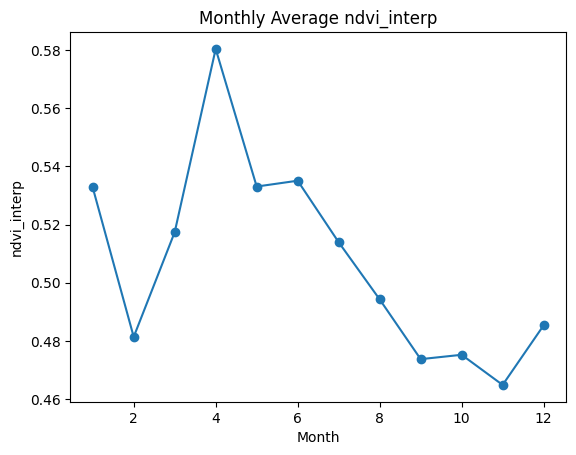

        ---------------------------------------

##### This is my final dataset value graph that actually relies with the medditerrian place like pacific palisades. NOTE: There may be some error in the data but theoratically and practically it is correct

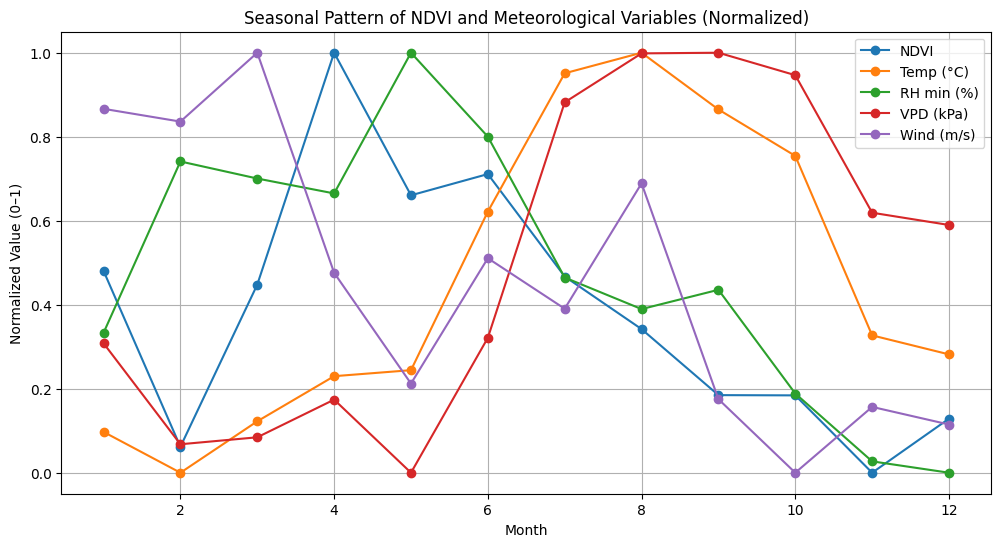

In [ ]:
## optional but usefull to make new order according your format
new_order = [
    'date','lat','lon',
    # weather
    'tmax_c','tmin_c','tmean_c','rh_max_pct','rh_min_pct','vpd_kpa','pr_mm','wind_ms','ndvi_interp',
    # fire indices
    'erc','bi',
    # topo
    'elevation','slope','aspect','northness','eastness','slope_cat',
    # human proximities
    'dist_to_urban_m','distance_to_roads_m','dist_to_powerplant_m','viirs_avg_rad_2024','worldpop_100m',
    # target
    'fire_label'
]

df_1= df_1[new_order]

In [ ]:
### Remeber to save it.

df_1.to_csv("Final_dataset.csv")